# 定义相关函数

In [12]:
import pandas as pd
from datetime import datetime

import rqalpha as rqa
import rqalpha_plus

import rqdatac as rqd
rqd.init()

import rqoptimizer as rqo

# ==========================生成目标组合===========================
    
def get_target_stock(date,benchmark):
    """选取当期中证500融券股票"""
    # 融券股票列表
    margin_stocks = rqd.get_margin_stocks(date=date,exchange=None,margin_type='stock')
     # 中证500成分股
    component = rqd.index_components(benchmark, date)
    # 取交集
    target_stock = list(set(component).intersection(margin_stocks))
    return target_stock


def get_target_portfolio(target_stock,date,benchmark):
    """按照产品设置, 计算目标组合"""
    # 定义目标函数和约束条件
    objective = rqo.MinTrackingError()
    
    # 行业中性
    industry_constraints = rqo.WildcardIndustryConstraint(
                                exclude=None,
                                lower_limit=-0.1,
                                upper_limit=0.1,
                                relative=True,
                                hard=True,
                                classification=rqo.IndustryClassification.ZX)
    # 风格约束
    style_constraints = rqo.StyleConstraint(
                                ['size','beta','non_linear_size'], 
                                lower_limit=-0.1, 
                                upper_limit=0.1, 
                                relative=True, 
                                hard=True)
    
    constraints = [industry_constraints, style_constraints]
    # 个股权重
    bnds = {}
    index_weights = rqd.index_weights(benchmark,date)
    for code in target_stock:
        stock_weight = index_weights.loc[code]
        bnds[code] = (max(0,stock_weight-0.05),stock_weight+0.05)
    
    target_portfolio = rqo.portfolio_optimize(target_stock,date, 
                                       benchmark=benchmark, 
                                       objective=objective,
                                       cons=constraints,
                                       bnds=bnds) 
    # 由于精度问题, 优化结果可能包含非常接近0的股票权重, 在此直接舍去
    return target_portfolio.loc[lambda x:x!=0]

# ========================回测相关==========================

def _should_rebalance(context):
    """判断今天是否调仓"""
    # 获得上一个交易日
    prev_trading_day = rqd.get_previous_trading_date(context.now)
    # 判断是否是月初, 是月初返回True
    is_month_start = (prev_trading_day.month != context.now.month)
    return is_month_start


def handle_bar(context, bar_dict):
    """按照调仓条件进行调仓"""
    if not _should_rebalance(context):
        return
    print("现有持仓:",len(context.portfolio.positions))
    target_stock= get_target_stock(context.now,context.benchmark)
    target_portfolio = get_target_portfolio(target_stock,context.now,context.benchmark)
    rebalance(context,bar_dict,target_portfolio)


def rebalance(context, bar_dict, target_portfolio):
    """根据目标组合, 计算其与当前持仓的差额, 进行调仓"""
    positions = context.stock_account.positions
    for order_book_id in positions:
        if order_book_id not in target_portfolio:
            rqa.api.order_to(order_book_id, 0)

    # 对每个股票计算目标价值和当前价值的差值
    # 差值为正的是买单, 反之为卖单
    capital = context.stock_account.total_value * (1 - context.cash_cushion)
    to_sell, to_buy = {}, {}

    def _money_for_one_lot(
        order_book_id): return bar_dict[order_book_id].close * 100

    for order_book_id, weight in target_portfolio.items():
        # 股票目标价值
        target_value = capital * weight
        # 目标和现有之差
        gap = target_value - positions[order_book_id].market_value
        # 买卖至少大于1手股票价值
        if abs(gap) < _money_for_one_lot(order_book_id):
            continue
        elif gap > 0:
            to_buy[order_book_id] = gap
        else:
            to_sell[order_book_id] = gap

    # 避免流动性问题,先卖出后买入
    for order_book_id, value in to_sell.items():
        rqa.api.order_value(order_book_id, value)
    for order_book_id, value in to_buy.items():
        rqa.api.order_value(order_book_id, value)

F:\anaconda\envs\ricequant\lib\site-packages\rqdatac\client.py:190: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


# 回测设置
- 起止日期: `2017-01-01`至`2020-08-17`
- 总资金: `1e8`
- 目标函数: `最小化跟踪误差`
- 行业约束: `与基准上下偏离0.1个标准差`
- 风格约束: `市值、beta、非线性市值与基准上下偏离0.1个标准差`
- 个股权重: `由于不允许做空,个股权重大于0但不超过基准0.05`

In [14]:
config = {
    "base": {
        "start_date": '2017-01-01',
        "end_date": '2020-08-17',
        "frequency": '1d',
        "accounts": {"stock": 1e8},
#         "data_bundle_path": r'C:\Users\Administrator\.rqalpha-plus\bundle'
    },

    "mod": {
        "sys_analyser": {
            "enabled": True,
            "plot": True,
            "benchmark": '000905.XSHG',
        },
    },

    "extra": {
        "log_level": 'error',
        "context_vars":{
            'benchmark':'000905.XSHG',
            'cash_cushion':0.005
        },
    },
}

F:\anaconda\envs\ricequant\lib\site-packages\rqdatac\client.py:190: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)
[2017-01-03 15:00:00.000000] INFO: user_log: 现有持仓: 0


WARN: aa_init returned NULL, no acceleration applied.


[2017-02-03 15:00:00.000000] INFO: user_log: 现有持仓: 330


WARN: aa_init returned NULL, no acceleration applied.


[2017-03-01 15:00:00.000000] INFO: user_log: 现有持仓: 335


WARN: aa_init returned NULL, no acceleration applied.


[2017-04-05 15:00:00.000000] INFO: user_log: 现有持仓: 337


WARN: aa_init returned NULL, no acceleration applied.


[2017-05-02 15:00:00.000000] INFO: user_log: 现有持仓: 342


WARN: aa_init returned NULL, no acceleration applied.


[2017-06-01 15:00:00.000000] INFO: user_log: 现有持仓: 344


WARN: aa_init returned NULL, no acceleration applied.


[2017-07-03 15:00:00.000000] INFO: user_log: 现有持仓: 349
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 银行 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)


WARN: aa_init returned NULL, no acceleration applied.


[2017-08-01 15:00:00.000000] INFO: user_log: 现有持仓: 344
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 银行 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)


WARN: aa_init returned NULL, no acceleration applied.


[2017-09-01 15:00:00.000000] INFO: user_log: 现有持仓: 349
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 银行 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)


WARN: aa_init returned NULL, no acceleration applied.


[2017-10-09 15:00:00.000000] INFO: user_log: 现有持仓: 350
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 银行 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)


WARN: aa_init returned NULL, no acceleration applied.


[2017-11-01 15:00:00.000000] INFO: user_log: 现有持仓: 349
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 银行 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)


WARN: aa_init returned NULL, no acceleration applied.


[2017-12-01 15:00:00.000000] INFO: user_log: 现有持仓: 348
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 银行 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)


WARN: aa_init returned NULL, no acceleration applied.


[2018-01-02 15:00:00.000000] INFO: user_log: 现有持仓: 349


WARN: aa_init returned NULL, no acceleration applied.


[2018-02-01 15:00:00.000000] INFO: user_log: 现有持仓: 347


WARN: aa_init returned NULL, no acceleration applied.


[2018-03-01 15:00:00.000000] INFO: user_log: 现有持仓: 349


WARN: aa_init returned NULL, no acceleration applied.


[2018-04-02 15:00:00.000000] INFO: user_log: 现有持仓: 348


WARN: aa_init returned NULL, no acceleration applied.


[2018-05-02 15:00:00.000000] INFO: user_log: 现有持仓: 348


WARN: aa_init returned NULL, no acceleration applied.


[2018-06-01 15:00:00.000000] INFO: user_log: 现有持仓: 347


WARN: aa_init returned NULL, no acceleration applied.


[2018-07-02 15:00:00.000000] INFO: user_log: 现有持仓: 347


WARN: aa_init returned NULL, no acceleration applied.


[2018-08-01 15:00:00.000000] INFO: user_log: 现有持仓: 339


WARN: aa_init returned NULL, no acceleration applied.


[2018-09-03 15:00:00.000000] INFO: user_log: 现有持仓: 340


WARN: aa_init returned NULL, no acceleration applied.


[2018-10-08 15:00:00.000000] INFO: user_log: 现有持仓: 338


WARN: aa_init returned NULL, no acceleration applied.


[2018-11-01 15:00:00.000000] INFO: user_log: 现有持仓: 337


WARN: aa_init returned NULL, no acceleration applied.


[2018-12-03 15:00:00.000000] INFO: user_log: 现有持仓: 338


WARN: aa_init returned NULL, no acceleration applied.


[2019-01-02 15:00:00.000000] INFO: user_log: 现有持仓: 337


WARN: aa_init returned NULL, no acceleration applied.


[2019-02-01 15:00:00.000000] INFO: user_log: 现有持仓: 334


WARN: aa_init returned NULL, no acceleration applied.


[2019-03-01 15:00:00.000000] INFO: user_log: 现有持仓: 332


WARN: aa_init returned NULL, no acceleration applied.


[2019-04-01 15:00:00.000000] INFO: user_log: 现有持仓: 332


WARN: aa_init returned NULL, no acceleration applied.


[2019-05-06 15:00:00.000000] INFO: user_log: 现有持仓: 333


WARN: aa_init returned NULL, no acceleration applied.


[2019-06-03 15:00:00.000000] INFO: user_log: 现有持仓: 332


WARN: aa_init returned NULL, no acceleration applied.


[2019-07-01 15:00:00.000000] INFO: user_log: 现有持仓: 330


WARN: aa_init returned NULL, no acceleration applied.


[2019-08-01 15:00:00.000000] INFO: user_log: 现有持仓: 323


WARN: aa_init returned NULL, no acceleration applied.


[2019-09-02 15:00:00.000000] INFO: user_log: 现有持仓: 325


WARN: aa_init returned NULL, no acceleration applied.


[2019-10-08 15:00:00.000000] INFO: user_log: 现有持仓: 456


WARN: aa_init returned NULL, no acceleration applied.


[2019-11-01 15:00:00.000000] INFO: user_log: 现有持仓: 462


WARN: aa_init returned NULL, no acceleration applied.


[2019-12-02 15:00:00.000000] INFO: user_log: 现有持仓: 462


WARN: aa_init returned NULL, no acceleration applied.


[2020-01-02 15:00:00.000000] INFO: user_log: 现有持仓: 462


WARN: aa_init returned NULL, no acceleration applied.


[2020-02-03 15:00:00.000000] INFO: user_log: 现有持仓: 463


WARN: aa_init returned NULL, no acceleration applied.


[2020-03-02 15:00:00.000000] INFO: user_log: 现有持仓: 463


WARN: aa_init returned NULL, no acceleration applied.


[2020-04-01 15:00:00.000000] INFO: user_log: 现有持仓: 463


WARN: aa_init returned NULL, no acceleration applied.


[2020-05-06 15:00:00.000000] INFO: user_log: 现有持仓: 463


WARN: aa_init returned NULL, no acceleration applied.


[2020-06-01 15:00:00.000000] INFO: user_log: 现有持仓: 463


WARN: aa_init returned NULL, no acceleration applied.


[2020-07-01 15:00:00.000000] INFO: user_log: 现有持仓: 459


WARN: aa_init returned NULL, no acceleration applied.


[2020-08-03 15:00:00.000000] INFO: user_log: 现有持仓: 465


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\mod\rqalpha_mod_sys_analyser\plot.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.2f}%'.format(x * 100) for x in vals])


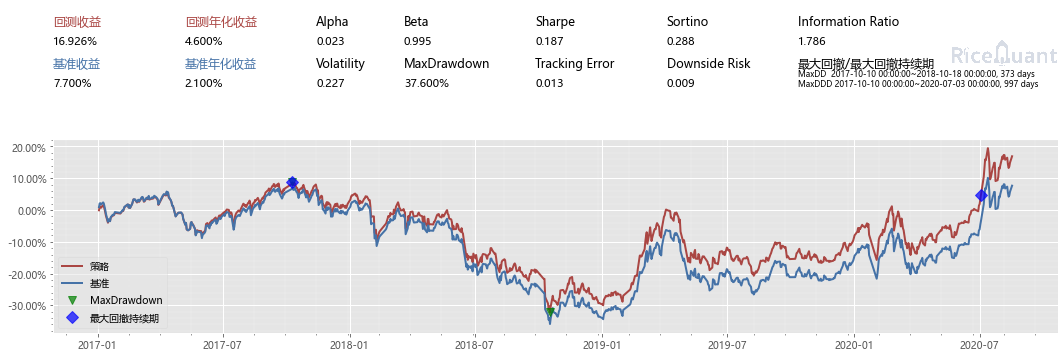

In [15]:
backtest_results = rqalpha_plus.run_func(handle_bar=handle_bar, config=config)

In [16]:
# ==================回测结果分析====================

def cumulative_excess_return(backtest_result):
    strat_portf = backtest_result['sys_analyser']['portfolio']
    benchmark_portf = backtest_result['sys_analyser']['benchmark_portfolio']
    
    strat_return = strat_portf['unit_net_value'].pct_change()
    benchmark_return = benchmark_portf['unit_net_value'].pct_change()
    
    excess_return = strat_return - benchmark_return
    
    return (excess_return).cumsum()+1
    
def stock_position_stats(backtest_result):
    market_value = backtest_result['sys_analyser']['stock_account']['market_value']
    total_value = backtest_result['sys_analyser']['stock_account']['total_value']
    percentage = market_value / total_value
    num_holdings = backtest_result['sys_analyser']['stock_positions'].groupby(level='date').size()
    return pd.DataFrame(
        {'market_value': market_value, 
         'total_value': total_value,
         'percentage': percentage,
         'num_holdings': num_holdings,
        })

<AxesSubplot:title={'center':'Cumulative Excess Return'}, xlabel='date'>

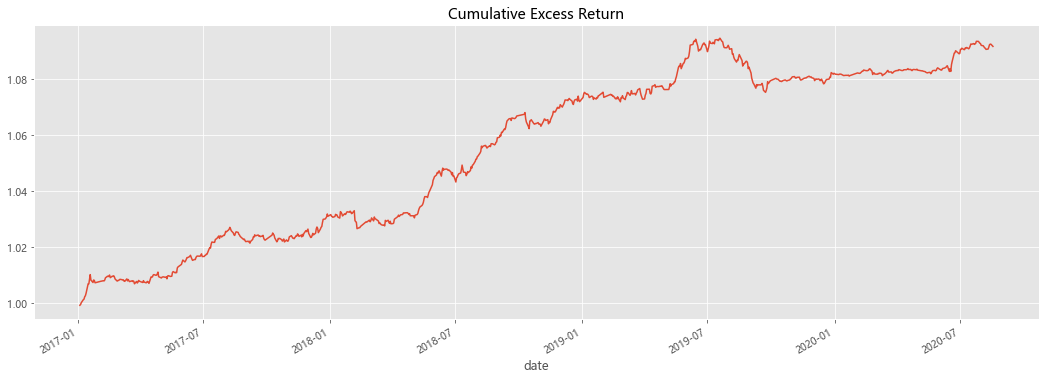

In [17]:
cumulative_excess_return(backtest_results).plot(title='Cumulative Excess Return', figsize=(18, 6))

<AxesSubplot:xlabel='date'>

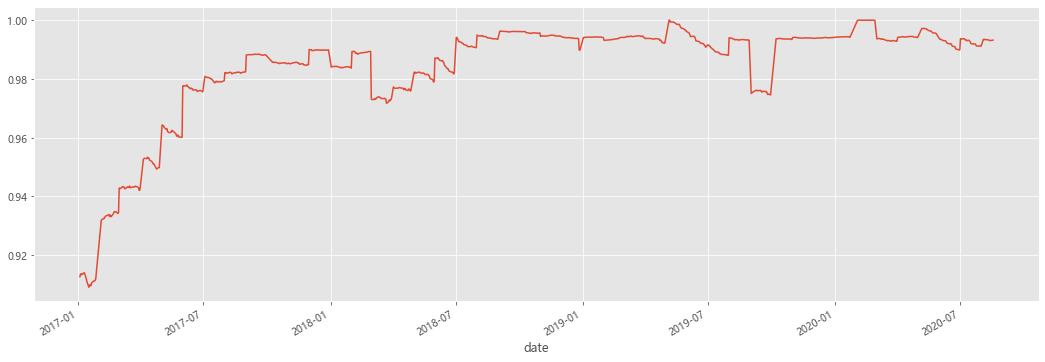

In [18]:
stock_position_stats(backtest_results)['percentage'].plot(figsize=(18, 6))